**Vebronia Bikolo-Machine Learning**

# **Analisis Sentimen Review Aplikasi Google Play Store**

Mengambil ulasan (review) aplikasi Vidio (ID aplikasi 'com.vidio.android') dari Google Play Store, kemudian memfilter ulasan tersebut berdasarkan tahun dan bulan yang ditentukan pengguna, dan terakhir menyimpan ulasan yang telah difilter ke dalam file CSV.

## Install Library

### Subtask:
Install library `google-play-scraper` yang akan digunakan untuk mengambil ulasan dari Google Play Store.


**Reasoning**:
The user wants to install the `google-play-scraper` library. I will use `!pip install` to install it.



In [ ]:
pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00


## Scrape Reviews for Vidio

### Subtask:
Ambil ulasan untuk aplikasi Vidio (dengan app ID 'com.vidio.android') dari Google Play Store. Kode ini akan mencoba mengambil sejumlah besar ulasan untuk kemudian difilter, karena filter langsung berdasarkan tanggal tidak selalu tersedia di API.


**Reasoning**:
The subtask requires scraping reviews from the Google Play Store. I will use the `reviews` and `Sort` functions from the `google_play_scraper` library to fetch reviews for the specified application ID, convert them into a pandas DataFrame, and display the head of the DataFrame to verify the data.



**Langkah 1: Crawling dengan Play Store**

In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd
from datetime import datetime
import time

# --- KONFIGURASI ---
app_id = 'com.vidio.android'
lang = 'id'
country = 'id'

# Tentukan rentang tanggal yang diinginkan (Tahun, Bulan, Tanggal)
# Contoh: Mengambil review dari 1 Januari 2024 sampai 30 April 2024
tanggal_mulai = datetime(2025, 1, 1)
tanggal_akhir = datetime(2025, 11, 30)
# -------------------

result = []
continuation_token = None

print(f"Mulai scraping ulasan untuk {app_id}...")
print(f"Rentang: {tanggal_mulai.date()} s.d {tanggal_akhir.date()}")

while True:
    # Mengambil ulasan dalam batch (per 100-300 ulasan)
    scrapreview, continuation_token = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=Sort.NEWEST, # Penting: Urutkan dari yang terbaru
        count=100,
        continuation_token=continuation_token
    )

    # Jika tidak ada ulasan lagi, berhenti
    if not scrapreview:
        break

    for review in scrapreview:
        review_date = review['at'] # Mengambil tanggal ulasan

        # Logika Filter Tanggal
        if review_date > tanggal_akhir:
            continue # Lewati jika ulasan lebih baru dari tanggal_akhir

        if review_date < tanggal_mulai:
            # Karena sudah diurutkan NEWEST, jika ketemu tanggal yang lebih tua
            # dari tanggal_mulai, berarti sisa data di belakang pasti lebih tua lagi.
            # Maka kita hentikan proses loop utamanya.
            continuation_token = None
            break

        # Jika lolos filter, simpan ke list result
        result.append(review)

    # Jika token habis (sudah mencapai batas bawah tanggal), keluar dari while
    if continuation_token is None:
        break

    # Opsional: Memberi jeda sedikit agar tidak dianggap spamming request
    time.sleep(0.5)

Mulai scraping ulasan untuk com.vidio.android...
Rentang: 2025-01-01 s.d 2025-11-30


**Reasoning**:
The previous attempt to scrape reviews resulted in an empty DataFrame, likely due to the `google-play-scraper` library's instability or how it handles large `count` parameters in a single call. To ensure a more robust scraping process, I will implement manual pagination by fetching reviews in smaller batches and using the `continuation_token`.



In [ ]:
# --- MENYIMPAN DATA ---

# Membuat DataFrame
app_reviews_df = pd.DataFrame(result)

# Menampilkan info singkat
print(f"\nSelesai! Berhasil mendapatkan {len(app_reviews_df)} ulasan.")
if not app_reviews_df.empty:
    print("Contoh data teratas:")
    print(app_reviews_df[['content', 'at', 'score']].head())

    # Menyimpan ke CSV (hanya kolom content/review sesuai kodemu sebelumnya)
    # Namun saya sarankan simpan juga tanggal dan score untuk analisis lebih lanjut
    app_reviews_df.to_csv('review_vidio_filtered.csv', index=False, encoding='utf-8')
    print("\nFile tersimpan sebagai 'review_vidio_filtered.csv'")
else:
    print("Tidak ada ulasan ditemukan pada rentang tanggal tersebut.")


Selesai! Berhasil mendapatkan 11041 ulasan.
Contoh data teratas:
                                             content                  at  \
0                                              bagus 2025-11-29 22:47:48   
1  aneh biasa nya bayar pakai google play bisa in... 2025-11-29 20:02:10   
2  NAJIS, MENDING NETFLIX, BAYAR BULANAN UDAH PUA... 2025-11-29 18:50:06   
3                                             mantap 2025-11-29 17:45:53   
4  Mohon maaf akhir akhir ini mau bayar langganan... 2025-11-29 15:08:22   

   score  
0      3  
1      3  
2      1  
3      5  
4      2  

File tersimpan sebagai 'review_vidio_filtered.csv'


# **Pra-Pemrossesan**

### **Langkah 1. Case Folding & Cleaning**

In [ ]:
import pandas as pd
import re

# 1. Memuat data yang sudah dicrawling sebelumnya
# Pastikan nama filenya sesuai dengan yang kamu simpan
df = pd.read_csv('review_vidio_filtered.csv')

# Menangani nilai kosong (jika ada kolom yang kosong terbaca sebagai NaN)
df['content'] = df['content'].astype(str)

# 2. Membuat fungsi pembersih (Cleaning Function)
def cleaning_text(text):
    # a. Case Folding: Mengubah semua huruf menjadi huruf kecil (lowercase)
    # Agar "Bagus" dan "bagus" dianggap kata yang sama
    text = text.lower()

    # b. Menghapus Newline: Menghapus baris baru (\n) ganti dengan spasi
    text = re.sub(r'\n', ' ', text)

    # c. Menghapus Mention/Username (misal @mandiri) - Opsional
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # d. Menghapus URL/Link (http://...)
    text = re.sub(r'http\S+', '', text)

    # e. Menghapus Angka (jika analisis sentimen tidak butuh angka)
    text = re.sub(r'\d+', '', text)

    # f. Menghapus Tanda Baca dan Karakter Spesial (Emoji, #, !, ?, dll)
    # Pola [^\w\s] berarti: Hapus apa pun yang BUKAN huruf atau spasi
    text = re.sub(r'[^\w\s]', ' ', text)

    # g. Menghapus Spasi Berlebih (Whitespace control)
    # Mengubah spasi ganda menjadi satu spasi
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 3. Menerapkan fungsi ke kolom review
print("Sedang membersihkan data...")
df['cleaned_content'] = df['content'].apply(cleaning_text)

# 4. Melihat Perbandingan Sebelum dan Sesudah
print("\nContoh Hasil Cleaning:")
# Kita lihat 5 data pertama untuk membandingkan
pd.set_option('display.max_colwidth', 100) # Agar teks terlihat penuh
print(df[['content', 'cleaned_content']].head())

# 5. Menyimpan hasil bersih ke CSV baru
df.to_csv('review_vidio_clean.csv', index=False)
print("\nData bersih tersimpan di 'review_vidio_clean.csv'")

Sedang membersihkan data...

Contoh Hasil Cleaning:
                                                                                               content  \
0                                                                                                bagus   
1  aneh biasa nya bayar pakai google play bisa ini kok ndak bisa yah padahal saldo nya sangat sanga...   
2  NAJIS, MENDING NETFLIX, BAYAR BULANAN UDAH PUAS NONTON APA SAJA. INI MAH VIDIO NIPUIN ORANG, BAY...   
3                                                                                               mantap   
4  Mohon maaf akhir akhir ini mau bayar langganan pakai dana kok ditolak ya, padahal akun dana sama...   

                                                                                       cleaned_content  
0                                                                                                bagus  
1  aneh biasa nya bayar pakai google play bisa ini kok ndak bisa yah padahal saldo nya sangat sanga..

:### **Langkah 2. Tokenisasi (Tokenization)**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# --- LANGKAH 0: DOWNLOAD PACKAGE NLTK ---
# NLTK membutuhkan model bahasa untuk mengetahui cara memisah kata (tokenizer)
# Baris ini cukup dijalankan sekali saja
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# 1. Memuat data bersih (jika melanjutkan dari sesi sebelumnya, lewati baris ini)
# df = pd.read_csv('review_vidio_clean.csv')

# 2. Fungsi Tokenization
def tokenizing_text(text):
    # word_tokenize akan memecah kalimat menjadi list kata
    return word_tokenize(text)

# 3. Menerapkan fungsi ke kolom yang sudah dibersihkan
print("Sedang melakukan tokenisasi...")
df['tokenized_content'] = df['cleaned_content'].apply(tokenizing_text)

# 4. Melihat Hasil
print("\nContoh Hasil Tokenization:")
print(df[['cleaned_content', 'tokenized_content']].head())

# Cek tipe datanya untuk memastikan ini sudah menjadi List
print(f"\nTipe data kolom tokenized: {type(df['tokenized_content'].iloc[0])}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sedang melakukan tokenisasi...

Contoh Hasil Tokenization:
                                                                                       cleaned_content  \
0                                                                                                bagus   
1  aneh biasa nya bayar pakai google play bisa ini kok ndak bisa yah padahal saldo nya sangat sanga...   
2  najis mending netflix bayar bulanan udah puas nonton apa saja ini mah vidio nipuin orang bayar b...   
3                                                                                               mantap   
4  mohon maaf akhir akhir ini mau bayar langganan pakai dana kok ditolak ya padahal akun dana sama ...   

                                                                                     tokenized_content  
0                                                                                              [bagus]  
1  [aneh, biasa, nya, bayar, pakai, google, play, bisa, ini, kok, ndak, bisa, yah, padahal, sa

### **Penjelasan untuk Materi Praktikum**
**nltk.download('punkt'):** Ini adalah langkah penting. NLTK tidak memuat semua data bahasanya secara langsung agar ringan. Kita perlu mengunduh modul punkt (pre-trained tokenizer) agar NLTK tahu aturan pemisahan kata.

**Perbedaan Struktur Data:**

Kolom cleaned_content berisi String (teks biasa).

Kolom tokenized_content berisi List (daftar kata). Ini penting karena komputer akan memproses analisis sentimen kata per kata dari dalam list ini.

### **Langkah 3. Stopword Removal (Filtering)**

Kode Stopword Removal (Menggunakan Sastrawi)

**Catatan:** Pastikan mahasiswa menginstall Sastrawi terlebih dahulu dengan pip install Sastrawi.


In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import pandas as pd

# 1. Mengambil daftar stopword bawaan Sastrawi
factory = StopWordRemoverFactory()
stopwords_indonesia = factory.get_stop_words()

# 2. Menambahkan Stopword Tambahan (Custom)
# Review aplikasi sering mengandung kata gaul yang tidak penting untuk sentimen
stopwords_tambahan = [
    'sih', 'dong', 'kok', 'tuh', 'yah', 'ni', 'nih', 'g', 'tp',
    'yg', 'ga', 'gak', 'kalo', 'klo', 'nya', 'aja', 'biar'
]

# Menggabungkan stopword sastrawi + tambahan
# Kita gunakan set() agar pencarian data jauh lebih cepat daripada list
list_stopwords = set(stopwords_indonesia + stopwords_tambahan)

# 3. Fungsi Stopword Removal
def remove_stopwords(tokens):
    # tokens adalah list kata dari proses tokenisasi sebelumnya
    # Logika: Ambil kata JIKA kata tersebut TIDAK ADA di dalam list_stopwords
    return [word for word in tokens if word not in list_stopwords]

# 4. Menerapkan fungsi ke kolom tokenized
print("Sedang memfilter kata (Stopword Removal)...")
df['stopword_removed'] = df['tokenized_content'].apply(remove_stopwords)

# 5. Melihat Hasil
print("\nContoh Hasil Stopword Removal:")
print(df[['tokenized_content', 'stopword_removed']].head())

# Simpan hasilnya (opsional)
df.to_csv('review_vidio_stopword.csv', index=False)

Sedang memfilter kata (Stopword Removal)...

Contoh Hasil Stopword Removal:
                                                                                     tokenized_content  \
0                                                                                              [bagus]   
1  [aneh, biasa, nya, bayar, pakai, google, play, bisa, ini, kok, ndak, bisa, yah, padahal, saldo, ...   
2  [najis, mending, netflix, bayar, bulanan, udah, puas, nonton, apa, saja, ini, mah, vidio, nipuin...   
3                                                                                             [mantap]   
4  [mohon, maaf, akhir, akhir, ini, mau, bayar, langganan, pakai, dana, kok, ditolak, ya, padahal, ...   

                                                                                      stopword_removed  
0                                                                                              [bagus]  
1  [aneh, biasa, bayar, pakai, google, play, ndak, padahal, saldo, sangat, sa

### **Penjelasan Penting untuk Praktikum**
**pip install Sastrawi:** Beritahu mahasiswa bahwa ini adalah pustaka eksternal khusus bahasa Indonesia yang harus diinstal, berbeda dengan re atau csv yang bawaan Python.

**Mengapa pakai set()?:**

Di baris list_stopwords = set(...), kita mengubah daftar menjadi himpunan (set).

Dalam pemrograman, mengecek apakah sebuah kata ada di dalam set jauh lebih cepat (O(1)) dibandingkan mengecek di dalam list (O(n)), terutama jika datanya ribuan.

**Custom Stopwords:** Ini bagian paling interaktif. Ajak mahasiswa melihat hasil CSV. Jika mereka masih melihat kata sampah seperti "wkwk" atau "hadeh", minta mereka menambahkannya ke dalam list stopwords_tambahan di kode tersebut.

### **Langkah 4. Stemming (Penting untuk Bhs. Indonesia)**

Kita akan mengubah kolom stopword_removed (yang berupa List) kembali menjadi kalimat utuh (String) yang sudah distem.


In [ ]:
import time
from multiprocessing import Pool, cpu_count
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from functools import lru_cache
from tqdm import tqdm

# =========================================================
# Membuat stemmer (sekali saja, global)
# =========================================================
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# =========================================================
# Fungsi stemming dengan caching
# =========================================================
@lru_cache(maxsize=None)
def cached_stem(text):
    """Fungsi stemming dengan cache (menyimpan hasil kata yang sudah pernah diproses)."""
    return stemmer.stem(text)

def stemmingText(text):
    """Fungsi stemming untuk multiprocessing"""
    if not isinstance(text, str):
        return ""
    return cached_stem(text)

# =========================================================
# Jalankan Multiprocessing + Benchmark
# =========================================================
if __name__ == "__main__":
    start_time = time.time()

    # Gunakan semua core CPU
    n_cores = cpu_count()
    print(f"Memulai stemming menggunakan {n_cores} core CPU ...\n")

    texts = df['stopword_removed'].astype(str).tolist()

    # Gunakan tqdm untuk progress bar
    with Pool(n_cores) as p:
        results = list(tqdm(p.imap(stemmingText, texts), total=len(texts)))

    # Simpan hasil ke DataFrame
    df['stemmed_content'] = results

    end_time = time.time()
    total_time = end_time - start_time

    print("\n✅ Proses stemming selesai!")
    print(f"Waktu total: {total_time:.2f} detik")
    print(f"Kecepatan rata-rata: {len(df) / total_time:.2f} teks/detik\n")


    # 5. Melihat Hasil
    print("\nContoh Hasil Stopword Removal:")
    print(df[['stemmed_content', 'stopword_removed']].head())

    # Simpan hasilnya (opsional)
    df.to_csv('review_vidio_stemming.csv', index=False)


Memulai stemming menggunakan 2 core CPU ...



100%|██████████| 11041/11041 [16:34<00:00, 11.11it/s]



✅ Proses stemming selesai!
Waktu total: 994.11 detik
Kecepatan rata-rata: 11.11 teks/detik


Contoh Hasil Stopword Removal:
                                                                                       stemmed_content  \
0                                                                                                bagus   
1            aneh biasa bayar pakai google play ndak padahal saldo sangat sangat cukup dii baik sistem   
2  najis mending netflix bayar bulan udah puas nonton apa mah vidio nipuin orang bayar bulan nonton...   
3                                                                                               mantap   
4  mohon maaf akhir akhir mau bayar langgan pakai dana tolak padahal akun dana sama google hubung s...   

                                                                                      stopword_removed  
0                                                                                              [bagus]  
1  [aneh, biasa, bayar, paka

## **3. Labeling Data (Anotasi)**

**OPSI 1:** Menggunakan Kamus "InSet" (Terbaik untuk Lexicon Based)
Kita akan mengambil datanya langsung dari repository GitHub pembuatnya agar Anda tidak perlu download file manual.

In [ ]:
import pandas as pd
import urllib.request

# 1. Load Data Hasil Stemming (Sastrawi)
df = pd.read_csv('review_vidio_stemming.csv')
df['stemmed_content'] = df['stemmed_content'].astype(str)

# ======================================================
# 2. Download & Load Kamus InSet (Langsung dari Sumbernya)
# ======================================================
print("Sedang mengunduh Lexicon InSet...")

# URL Lexicon Positif & Negatif (Sumber: Fajri Koto GitHub)
url_pos = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
url_neg = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

# Membaca file TSV (Tab Separated Values) langsung ke DataFrame
lexicon_pos = pd.read_csv(url_pos, sep='\t')
lexicon_neg = pd.read_csv(url_neg, sep='\t')

# Ubah ke bentuk Dictionary agar pencarian cepat: {'kata': skor}
# Contoh: {'bagus': 4, 'keren': 5}
dict_pos = dict(zip(lexicon_pos['word'], lexicon_pos['weight']))
dict_neg = dict(zip(lexicon_neg['word'], lexicon_neg['weight']))

# Gabungkan kedua kamus
lexicon_inset = {**dict_pos, **dict_neg}

print(f"Jumlah kata di kamus InSet: {len(lexicon_inset)} kata.")

# ======================================================
# 3. Fungsi Labeling dengan Skor (Weighting)
# ======================================================
def labeling_inset(text):
    words = text.split()
    score = 0

    for word in words:
        # Jika kata ada di dalam kamus InSet, ambil skornya
        if word in lexicon_inset:
            score += lexicon_inset[word]

    # Tentukan Label
    if score > 0:
        return 'Positif'
    elif score < 0:
        return 'Negatif'
    else:
        return 'Netral'

# ======================================================
# 4. Eksekusi
# ======================================================
print("Melakukan pelabelan menggunakan InSet...")
df['sentiment_label'] = df['stemmed_content'].apply(labeling_inset)

# Cek Hasil
print(df[['stemmed_content', 'sentiment_label']].head(10))
print("\nStatistik Label:")
print(df['sentiment_label'].value_counts())

df.to_csv('review_vidio_labeled_inset.csv', index=False)

Sedang mengunduh Lexicon InSet...
Jumlah kata di kamus InSet: 9074 kata.
Melakukan pelabelan menggunakan InSet...
                                                                                       stemmed_content  \
0                                                                                                bagus   
1            aneh biasa bayar pakai google play ndak padahal saldo sangat sangat cukup dii baik sistem   
2  najis mending netflix bayar bulan udah puas nonton apa mah vidio nipuin orang bayar bulan nonton...   
3                                                                                               mantap   
4  mohon maaf akhir akhir mau bayar langgan pakai dana tolak padahal akun dana sama google hubung s...   
5  kurang erti soal aplikasi vidio kurang paham krn mau cari film tau judul tiba dech aplikasi epis...   
6                           kode vocher guna udah bela bain beli lewat apk kredivo kode vochernya guna   
7                                  car

**OPSI 2:** Menggunakan Model Pre-trained (IndoBERT / RoBERTa)
Ini adalah "Teknik Terbaru". Kita tidak pakai Sastrawi, tidak pakai Stemming, dan tidak pakai Kamus CSV. Kita langsung masukkan kalimat mentah ke model yang sudah jadi.
Model yang populer dan siap pakai di HuggingFace adalah w11wo/indonesian-roberta-base-sentiment-classifier.


In [ ]:
from transformers import pipeline
import pandas as pd

# 1. Load Data Mentah (PENTING: Model ini butuh kalimat utuh, JANGAN pakai data stemming)
# Gunakan data hasil cleaning saja, atau bahkan data asli
df_indobert= pd.read_csv('review_vidio_clean.csv')
# Ambil sampel saja dulu untuk demo (karena prosesnya agak berat)
#df_sample = df.head(50).copy()

# ======================================================
# 2. Load Model IndoBERT (Sentiment Analysis)
# ======================================================
print("Sedang memuat Model IndoBERT (Mungkin butuh waktu download di awal)...")

# Kita gunakan pipeline siap pakai
# Model ini sudah dilatih khusus untuk sentimen (Positif, Negatif, Netral)
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp_model = pipeline("sentiment-analysis", model=pretrained_name, tokenizer=pretrained_name)

# ======================================================
# 3. Fungsi Prediksi
# ======================================================
def predict_indobert(text):
    # Model deep learning punya batasan panjang karakter (biasanya 512 token)
    # Kita potong teks jika terlalu panjang agar tidak error
    try:
        result = nlp_model(text[:512])[0]
        return result['label'] # Outputnya: 'positive', 'negative', atau 'neutral'
    except:
        return 'neutral'

# ======================================================
# 4. Eksekusi
# ======================================================
print("Melakukan prediksi sentimen...")
df_indobert['label_indobert'] = df_indobert['cleaned_content'].apply(predict_indobert)

# Tampilkan
print(df_indobert[['cleaned_content', 'label_indobert']].head(10))

# Mapping agar bahasa seragam (English -> Indo)
label_map = {'positive': 'Positif', 'negative': 'Negatif', 'neutral': 'Netral'}
df_indobert['label_indobert'] = df_indobert['label_indobert'].map(label_map)

Sedang memuat Model IndoBERT (Mungkin butuh waktu download di awal)...


Device set to use cpu


Melakukan prediksi sentimen...
                                                                                       cleaned_content  \
0                                                                                                bagus   
1  aneh biasa nya bayar pakai google play bisa ini kok ndak bisa yah padahal saldo nya sangat sanga...   
2  najis mending netflix bayar bulanan udah puas nonton apa saja ini mah vidio nipuin orang bayar b...   
3                                                                                               mantap   
4  mohon maaf akhir akhir ini mau bayar langganan pakai dana kok ditolak ya padahal akun dana sama ...   
5  klo saya masih kurang mengerti soal aplikasi vidio ini dan kurang paham sih krn klo mau mencari ...   
6  kode vocher tidak bisa digunakan saya udah bela belain beli lewat apk kredivo setelah ada kode v...   
7  cara menutuskan apk ini di langganan sya sudah putuskan tapi masih sja terpotong ini bgaimna car...   
8              

In [ ]:
# Cek Hasil
print(df_indobert[['cleaned_content', 'label_indobert']].head(10))
print("\nStatistik Label:")
print(df_indobert['label_indobert'].value_counts())

df_indobert.to_csv('review_vidio_labeled_indobert.csv', index=False)

                                                                                       cleaned_content  \
0                                                                                                bagus   
1  aneh biasa nya bayar pakai google play bisa ini kok ndak bisa yah padahal saldo nya sangat sanga...   
2  najis mending netflix bayar bulanan udah puas nonton apa saja ini mah vidio nipuin orang bayar b...   
3                                                                                               mantap   
4  mohon maaf akhir akhir ini mau bayar langganan pakai dana kok ditolak ya padahal akun dana sama ...   
5  klo saya masih kurang mengerti soal aplikasi vidio ini dan kurang paham sih krn klo mau mencari ...   
6  kode vocher tidak bisa digunakan saya udah bela belain beli lewat apk kredivo setelah ada kode v...   
7  cara menutuskan apk ini di langganan sya sudah putuskan tapi masih sja terpotong ini bgaimna car...   
8                                             

In [ ]:
pip install wordcloud matplotlib

### **NB:**

* **Jika pakai Metode Klasik (Lexicon / Naive Bayes / SVM):** Wajib Stemming (Sastrawi/IndoNLP). Karena algoritma ini bodoh, dia cuma menghitung frekuensi kata. Dia harus diberi tahu bahwa "membantu" dan "bantu" adalah hal yang sama agar hitungannya akurat.

* **Jika pakai Deep Learning (IndoBERT / LSTM):** DILARANG Stemming. Biarkan kalimatnya utuh (hanya bersihkan simbol/emoji saja). Biarkan model cerdas itu yang mencari polanya sendiri.


## **4.  Visualisasi: WordCloud**

Pastikan menginstall library pip install wordcloud matplotlib.

Data hasil Labeling **OPSI 1**

--- WordCloud Sentimen POSITIF ---


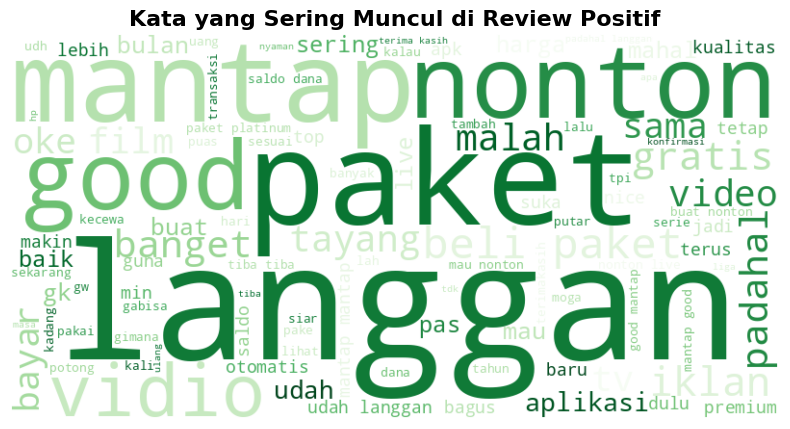


--- WordCloud Sentimen NEGATIF ---


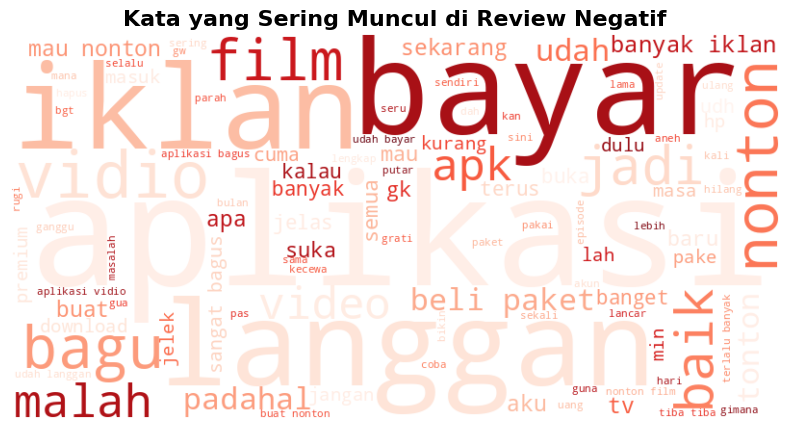


--- WordCloud Sentimen NETRAL ---


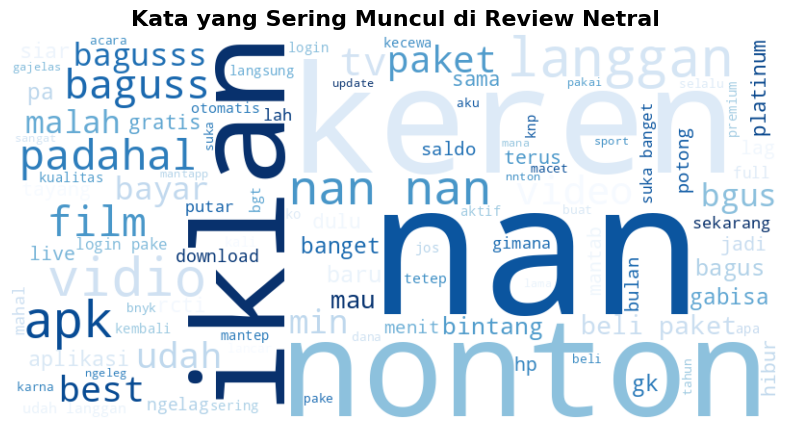

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Load Data Berlabel (Hasil tahap sebelumnya)
# Pastikan menggunakan data yang sudah dilabeli (Lexicon InSet)
try:
    df = pd.read_csv('review_vidio_labeled_inset.csv')
except FileNotFoundError:
    print("File tidak ditemukan. Pastikan nama file benar.")

# ======================================================
# 2. Fungsi Pembuat WordCloud
# ======================================================
def generate_wordcloud(text_data, title, color_theme):
    # WordCloud butuh input berupa satu string panjang, bukan list
    # Jadi kita gabungkan semua baris menjadi satu paragraf raksasa
    all_text = ' '.join(text_data)

    # Membuat objek WordCloud
    # width/height: resolusi gambar
    # max_words: jumlah kata terbanyak yang ditampilkan
    # background_color: warna latar (putih/hitam)
    # colormap: tema warna huruf
    wc = WordCloud(width=800, height=400,
                   max_words=100,
                   background_color='white',
                   colormap=color_theme).generate(all_text)

    # Plotting gambar
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') # Hilangkan sumbu X dan Y agar rapi
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

# ======================================================
# 3. Menampilkan WordCloud per Kategori
# ======================================================

# A. WordCloud POSITIF
print("--- WordCloud Sentimen POSITIF ---")
# Ambil hanya data yang labelnya 'Positif' dan kolom 'stemmed_content'
data_positif = df[df['sentiment_label'] == 'Positif']['stemmed_content'].astype(str)

if not data_positif.empty:
    # Gunakan colormap 'viridis' atau 'Greens' untuk nuansa positif
    generate_wordcloud(data_positif, "Kata yang Sering Muncul di Review Positif", "Greens")
else:
    print("Tidak ada data Positif.")

# B. WordCloud NEGATIF
print("\n--- WordCloud Sentimen NEGATIF ---")
data_negatif = df[df['sentiment_label'] == 'Negatif']['stemmed_content'].astype(str)

if not data_negatif.empty:
    # Gunakan colormap 'Reds' atau 'inferno' untuk nuansa negatif/marah
    generate_wordcloud(data_negatif, "Kata yang Sering Muncul di Review Negatif", "Reds")
else:
    print("Tidak ada data Negatif.")

# C. WordCloud NETRAL (Opsional)
print("\n--- WordCloud Sentimen NETRAL ---")
data_netral = df[df['sentiment_label'] == 'Netral']['stemmed_content'].astype(str)

if not data_netral.empty:
    generate_wordcloud(data_netral, "Kata yang Sering Muncul di Review Netral", "Blues")

**Data hasil Labeling OPSI 2**

--- WordCloud Sentimen POSITIF ---


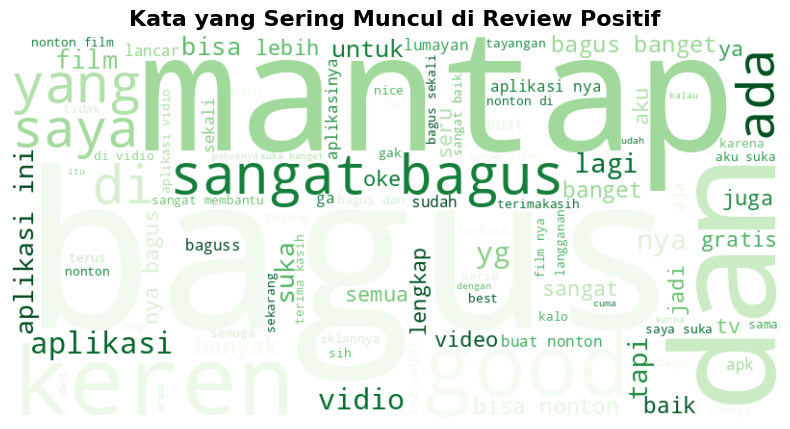


--- WordCloud Sentimen NEGATIF ---


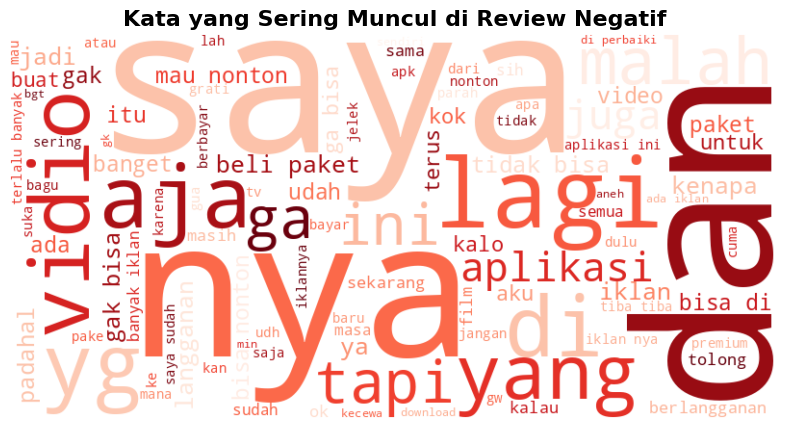


--- WordCloud Sentimen NETRAL ---


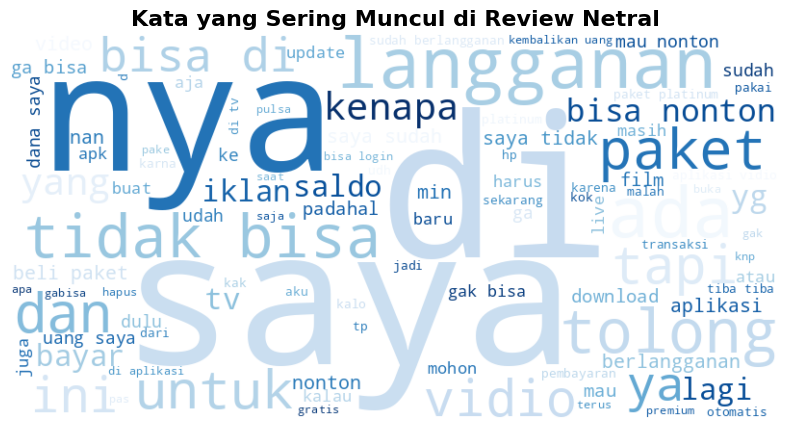

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Load Data Berlabel (Hasil tahap sebelumnya)
# Pastikan menggunakan data yang sudah dilabeli (Lexicon InSet)
try:
    df = pd.read_csv('review_vidio_labeled_indobert.csv')
except FileNotFoundError:
    print("File tidak ditemukan. Pastikan nama file benar.")

# ======================================================
# 2. Fungsi Pembuat WordCloud
# ======================================================
def generate_wordcloud(text_data, title, color_theme):
    # WordCloud butuh input berupa satu string panjang, bukan list
    # Jadi kita gabungkan semua baris menjadi satu paragraf raksasa
    all_text = ' '.join(text_data)

    # Membuat objek WordCloud
    # width/height: resolusi gambar
    # max_words: jumlah kata terbanyak yang ditampilkan
    # background_color: warna latar (putih/hitam)
    # colormap: tema warna huruf
    wc = WordCloud(width=800, height=400,
                   max_words=100,
                   background_color='white',
                   colormap=color_theme).generate(all_text)

    # Plotting gambar
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') # Hilangkan sumbu X dan Y agar rapi
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

# ======================================================
# 3. Menampilkan WordCloud per Kategori
# ======================================================

# A. WordCloud POSITIF
print("--- WordCloud Sentimen POSITIF ---")
# Ambil hanya data yang labelnya 'Positif' dan kolom 'cleaned_content'
data_positif = df[df['label_indobert'] == 'Positif']['cleaned_content'].astype(str)

if not data_positif.empty:
    # Gunakan colormap 'viridis' atau 'Greens' untuk nuansa positif
    generate_wordcloud(data_positif, "Kata yang Sering Muncul di Review Positif", "Greens")
else:
    print("Tidak ada data Positif.")

# B. WordCloud NEGATIF
print("\n--- WordCloud Sentimen NEGATIF ---")
data_negatif = df[df['label_indobert'] == 'Negatif']['cleaned_content'].astype(str)

if not data_negatif.empty:
    # Gunakan colormap 'Reds' atau 'inferno' untuk nuansa negatif/marah
    generate_wordcloud(data_negatif, "Kata yang Sering Muncul di Review Negatif", "Reds")
else:
    print("Tidak ada data Negatif.")

# C. WordCloud NETRAL (Opsional)
print("\n--- WordCloud Sentimen NETRAL ---")
data_netral = df[df['label_indobert'] == 'Netral']['cleaned_content'].astype(str)

if not data_netral.empty:
    generate_wordcloud(data_netral, "Kata yang Sering Muncul di Review Netral", "Blues")

## **5.  Representasi Teks (Feature Engineering)**

Dalam kasus analisis sentiment untuk aplikasi play store yang sudah kita lakukan labeling dengan IndoBERT, Kita akan menggunakan pustaka scikit-learn yang merupakan standar industri untuk Machine Learning di Python untuk vektorisasi TF-IDF:


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# 1. Load Data Berlabel (Hasil Labeling InSet)
try:
    df = pd.read_csv('review_vidio_labeled_inset.csv')

    # Pastikan kolom teks tidak ada yang kosong (NaN)
    # Kita isi dengan string kosong jika ada NaN agar tidak error
    df['stemmed_content'] = df['stemmed_content'].fillna('')

except FileNotFoundError:
    print("File tidak ditemukan. Pastikan tahapan sebelumnya sudah dijalankan.")

# ======================================================
# 2. Inisialisasi TF-IDF Vectorizer
# ======================================================
# max_features=1000: Artinya kita hanya mengambil 1000 kata terpenting (top words)
# Tujuannya agar komputer tidak keberatan memproses puluhan ribu kata unik
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# ======================================================
# 3. Transformasi Teks menjadi Angka
# ======================================================
print("Sedang menghitung bobot TF-IDF...")

# fit_transform melakukan dua hal:
# 1. Mempelajari kosa kata dari seluruh data (fit)
# 2. Mengubah teks menjadi matriks angka (transform)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['stemmed_content'])

# ======================================================
# 4. Melihat Hasil (Visualisasi Matriks)
# ======================================================
# Mengubah matriks sparse menjadi DataFrame biasa agar mudah dibaca manusia
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

print("\n--- Bentuk Matriks TF-IDF ---")
print(f"Ukuran Matriks: {tfidf_df.shape}")
# Contoh: (1000, 1000) artinya 1000 review, dan 1000 kata unik

print("\n--- Contoh 5 Baris Data TF-IDF ---")
# Kita ambil sampel kolom (kata) secara acak untuk ditampilkan
print(tfidf_df.iloc[:5, :10]) # Menampilkan 5 baris pertama dan 10 kolom pertama

# ======================================================
# 5. Menyimpan Model TF-IDF
# ======================================================
# Kita perlu menyimpan 'rumus' vectorizer ini.
# Gunanya: Jika nanti ada data review baru, kita bisa ubah jadi angka
# dengan rumus yang sama persis.
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("\nModel TF-IDF berhasil disimpan sebagai 'tfidf_vectorizer.pkl'")

Sedang menghitung bobot TF-IDF...

--- Bentuk Matriks TF-IDF ---
Ukuran Matriks: (11041, 1000)

--- Contoh 5 Baris Data TF-IDF ---
   abis  abu  academy  acara   ad  ada  adain  adegan  adil  admin
0   0.0  0.0      0.0    0.0  0.0  0.0    0.0     0.0   0.0    0.0
1   0.0  0.0      0.0    0.0  0.0  0.0    0.0     0.0   0.0    0.0
2   0.0  0.0      0.0    0.0  0.0  0.0    0.0     0.0   0.0    0.0
3   0.0  0.0      0.0    0.0  0.0  0.0    0.0     0.0   0.0    0.0
4   0.0  0.0      0.0    0.0  0.0  0.0    0.0     0.0   0.0    0.0

Model TF-IDF berhasil disimpan sebagai 'tfidf_vectorizer.pkl'


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

# ================================================
# Download stopword Indonesia (sekali saja)
# ================================================
nltk.download('stopwords')

stopword_list = set(stopwords.words('indonesian'))

# 1. Load Data
df = pd.read_csv('review_vidio_labeled_indobert.csv')

# ======================================================
# Solusi error expected string or bytes-like object
# ======================================================
df['cleaned_content'] = df['cleaned_content'].fillna('')
df['cleaned_content'] = df['cleaned_content'].astype(str)

# ======================================================
# 2. Preprocessing (hapus stopword)
# ======================================================
def remove_stopwords(text):
    words = text.split()
    filtered = [w for w in words if w.lower() not in stopword_list]
    return ' '.join(filtered)

print("Membersihkan stopword...")
df['text_for_tfidf'] = df['cleaned_content'].apply(remove_stopwords)

# ======================================================
# 3. Proses TF-IDF
# ======================================================
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['text_for_tfidf'])

print("Sukses! Ukuran Matriks:", tfidf_matrix.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Membersihkan stopword...
Sukses! Ukuran Matriks: (11041, 1000)


### **Kesimpulan**
**Untuk Labeling (IndoBERT):** Pakai kalimat utuh/bersih (Jangan buang stopword).

**Untuk Vektorisasi (TF-IDF):** Wajib buang stopword dan lakukan tokenisasi (biasanya otomatis di dalam library TF-IDF, tapi inputnya harus bersih dari kata sambung).

## **6. Pemodelan: Machine Learning Tradisional**

### **Naive Bayes Classifier**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ======================================================
# 1. Definisi Variabel X dan y
# ======================================================
# X = Fitur (Matriks TF-IDF yang sudah kita buat sebelumnya)
X = tfidf_matrix

# y = Target (Label Sentimen)
# Pastikan nama kolom labelnya sesuai dengan file CSV kamu
# Jika pakai IndoBERT -> 'label_indobert' (atau yang sudah dimap jadi Positif/Negatif)
# Jika pakai InSet -> 'sentiment_label'
if 'label_indobert' in df.columns:
    y = df['label_indobert']
else:
    y = df['sentiment_label'] # Fallback jika pakai InSet

# ======================================================
# 2. Splitting Data (80% Train : 20% Test)
# ======================================================
# random_state=42 agar hasil acakannya konsisten setiap kali dijalankan
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Jumlah Data Latih: {X_train.shape[0]}")
print(f"Jumlah Data Uji: {X_test.shape[0]}")

Jumlah Data Latih: 8832
Jumlah Data Uji: 2209


In [ ]:
# ======================================================
# 3. Training Model (Naive Bayes)
# ======================================================
print("\nSedang melatih model Naive Bayes...")
model = MultinomialNB()
model.fit(X_train, y_train)
print("Selesai melatih model!")


Sedang melatih model Naive Bayes...
Selesai melatih model!


In [ ]:
# ======================================================
# 4. Evaluasi Model
# ======================================================
# Meminta model menebak data ujian (X_test)
y_pred = model.predict(X_test)

# Menghitung Akurasi
akurasi = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model: {akurasi * 100:.2f}%")

# Menampilkan Laporan Klasifikasi Detail
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Akurasi Model: 75.92%

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.73      0.92      0.81      1155
      Netral       0.55      0.11      0.19       283
     Positif       0.85      0.76      0.80       771

    accuracy                           0.76      2209
   macro avg       0.71      0.60      0.60      2209
weighted avg       0.75      0.76      0.73      2209



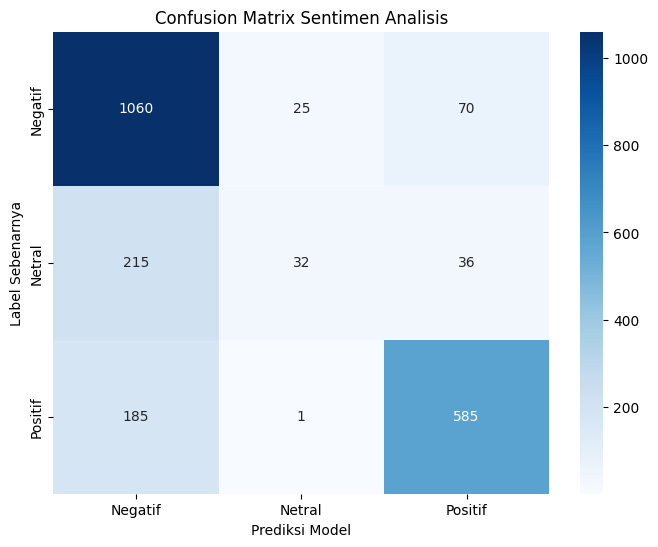

In [ ]:
# ======================================================
# 5. Visualisasi Confusion Matrix
# ======================================================
# Confusion Matrix berguna untuk melihat dimana model sering salah tebak
# Misal: Harusnya 'Negatif' tapi ditebak 'Positif'
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Sentimen Analisis')
plt.show()

### **Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC

# ======================================================
# 1. Training Model SVM
# ======================================================
# kernel='linear' biasanya bekerja paling baik untuk teks (TF-IDF)
print("Sedang melatih model SVM...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
print("Selesai melatih SVM!")

# ======================================================
# 2. Evaluasi SVM
# ======================================================
y_pred_svm = svm_model.predict(X_test)

# Menghitung Akurasi
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAkurasi SVM: {acc_svm * 100:.2f}%")
print(classification_report(y_test, y_pred_svm))

# Perbandingan Singkat
# (Biasanya SVM sedikit lebih tinggi dari Naive Bayes untuk data yang bersih)

Sedang melatih model SVM...
Selesai melatih SVM!

Akurasi SVM: 78.77%
              precision    recall  f1-score   support

     Negatif       0.79      0.88      0.83      1155
      Netral       0.60      0.26      0.36       283
     Positif       0.81      0.85      0.83       771

    accuracy                           0.79      2209
   macro avg       0.73      0.66      0.68      2209
weighted avg       0.77      0.79      0.77      2209



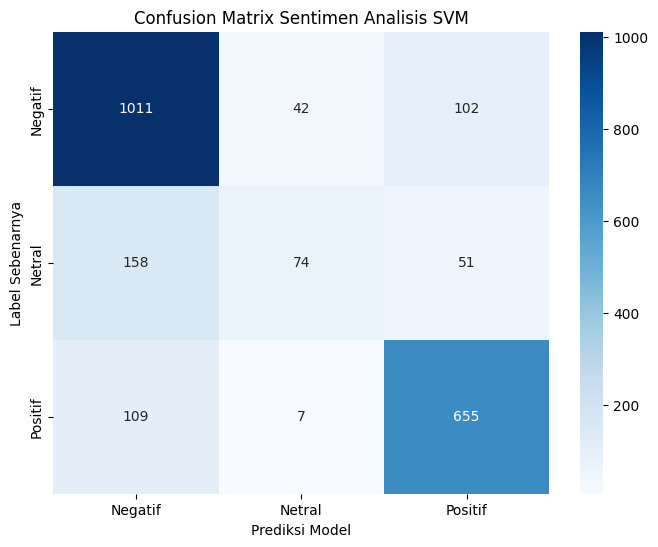

In [ ]:
# ======================================================
# 5. Visualisasi Confusion Matrix
# ======================================================
# Confusion Matrix berguna untuk melihat dimana model sering salah tebak
# Misal: Harusnya 'Negatif' tapi ditebak 'Positif'
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Sentimen Analisis SVM')
plt.show()

In [ ]:
import numpy as np
import tensorflow as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ======================================================
# 1. Persiapan Data Khusus Deep Learning (Sequence)
# ======================================================
# Kita gunakan data teks mentah yang sudah bersih
# Asumsi df['cleaned_content'] adalah teks bersih, dan df['label'] adalah target
texts = df['cleaned_content'].astype(str).values
labels = y  # Menggunakan label yang sama dengan sebelumnya

# A. Tokenisasi (Mengubah kata jadi angka indeks)
# max_words = 5000 kata terpopuler
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(texts)
X_seq = tokenizer.texts_to_sequences(texts)

# B. Padding (Menyamakan panjang kalimat)
# Deep learning butuh input panjangnya sama.
# Jika kalimat pendek, ditambah angka 0. Jika panjang, dipotong.
X_pad = pad_sequences(X_seq, maxlen=100) # maxlen 100 kata per ulasan

# C. Encoding Label (Ubah Positif/Negatif jadi 0, 1, 2)
le = LabelEncoder()
y_enc = le.fit_transform(labels)
# Ubah jadi one-hot encoding jika output > 2 kelas (misal: Pos, Neg, Net)
from tensorflow.keras.utils import to_categorical
y_final = to_categorical(y_enc)

# D. Splitting Data
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_final, test_size=0.2, random_state=42
)

print(f"Shape Data Latih DL: {X_train_dl.shape}")
print(f"Shape Label DL: {y_train_dl.shape}")

Shape Data Latih DL: (8832, 100)
Shape Label DL: (8832, 3)


In [ ]:
# ======================================================
# 2. Membangun Arsitektur BiLSTM
# ======================================================
model_dl = Sequential()

# Layer 1: Embedding (Mengubah angka indeks jadi vektor kata)
model_dl.add(Embedding(input_dim=5000, output_dim=128, input_length=100))

# Layer 2: Spatial Dropout (Mencegah Overfitting)
model_dl.add(SpatialDropout1D(0.2))

# Layer 3: BiLSTM (Otak utamanya)
# Membaca dari depan dan belakang
model_dl.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))

# Layer 4: Output Classifier
# Jumlah neuron = jumlah kelas sentimen (misal 3: Pos, Neg, Net)
# Activation 'softmax' untuk probabilitas multi-kelas
model_dl.add(Dense(y_final.shape[1], activation='softmax'))

model_dl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_dl.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# ======================================================
# 3. Training Model BiLSTM
# ======================================================
# batch_size: berapa data diproses sekaligus
# epochs: berapa kali belajar ulang
history = model_dl.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_dl, y_test_dl),
    verbose=1
)

Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 254ms/step - accuracy: 0.6628 - loss: 0.7793 - val_accuracy: 0.7949 - val_loss: 0.4999
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - accuracy: 0.8475 - loss: 0.4015 - val_accuracy: 0.8090 - val_loss: 0.4656
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 69s 251ms/step - accuracy: 0.8895 - loss: 0.2901 - val_accuracy: 0.8185 - val_loss: 0.4615
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 67s 243ms/step - accuracy: 0.9105 - loss: 0.2324 - val_accuracy: 0.8198 - val_loss: 0.4863
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 66s 241ms/step - accuracy: 0.9322 - loss: 0.1848 - val_accuracy: 0.8198 - val_loss: 0.5224


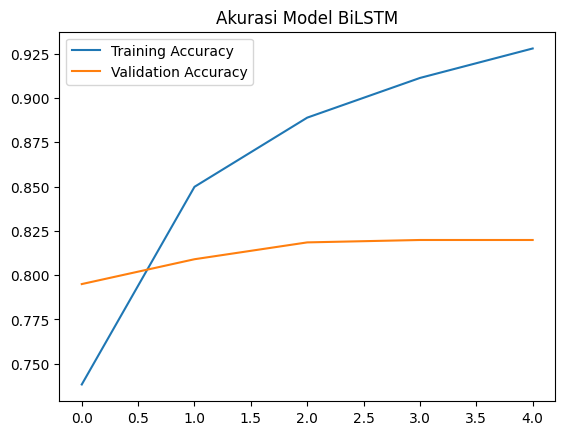


Akurasi BiLSTM: 81.98%


In [ ]:
# ======================================================
# 4. Evaluasi & Visualisasi
# ======================================================
# Plot Akurasi
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model BiLSTM')
plt.legend()
plt.show()

# Evaluasi Angka
loss, accuracy = model_dl.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"\nAkurasi BiLSTM: {accuracy * 100:.2f}%")

70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


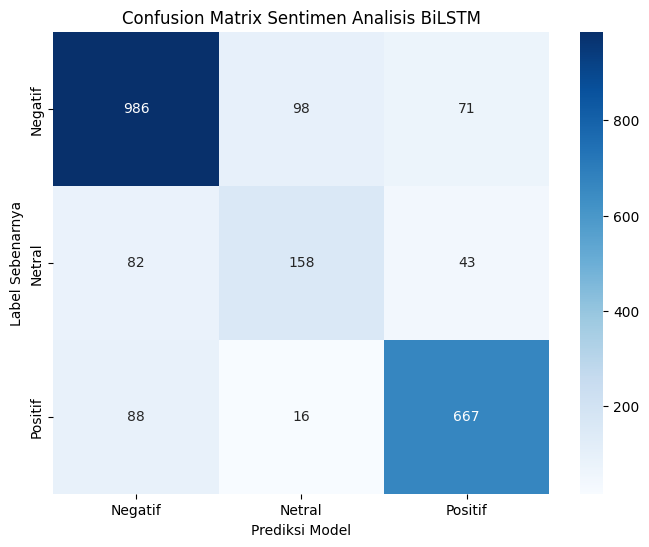

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi probabilitas kelas untuk data uji
y_pred_dl_prob = model_dl.predict(X_test_dl)

# Konversi probabilitas ke label kelas (indeks dengan probabilitas tertinggi)
y_pred_dl = np.argmax(y_pred_dl_prob, axis=1)
y_true_dl = np.argmax(y_test_dl, axis=1)

# Mengambil label asli dari LabelEncoder
# Pastikan 'le' (LabelEncoder) sudah didefinisikan dari sel sebelumnya.
# Jika tidak, perlu didefinisikan ulang atau dimuat.
class_labels = le.classes_

# Hitung Confusion Matrix
cm_bilstm = confusion_matrix(y_true_dl, y_pred_dl)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Sentimen Analisis BiLSTM')
plt.show()

## **Deployment / Prediksi Manual**
Kita akan membuat Interface Sederhana di mana kita bisa mengetik kalimat, lalu ketiga model (Naive Bayes, SVM, dan BiLSTM) akan berlomba memberikan prediksinya.


In [ ]:
import numpy as np
import re

# ======================================================
# 1. Fungsi Preprocessing (Wajib sama dengan Training)
# ======================================================
def clean_and_prepare(text):
    # 1. Cleaning standar (Lowercase, hapus simbol)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # (Opsional: Tambahkan stopword removal/stemming di sini jika diperlukan)
    return text

# ======================================================
# 2. Fungsi Prediksi Utama
# ======================================================
def predict_sentiment_all_models(text_input):
    print(f"\n--- Analisis untuk: '{text_input}' ---")

    # A. Preprocessing Data
    cleaned_text = clean_and_prepare(text_input)

    # ------------------------------------------------------
    # MODEL 1 & 2: Machine Learning Klasik (NB & SVM)
    # ------------------------------------------------------
    # Langkah Kritis: Gunakan .transform(), JANGAN .fit_transform()
    # Kita harus memakai "kamus" TF-IDF yang sama saat training
    text_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Prediksi Naive Bayes
    if 'model' in globals(): # Cek apakah model NB ada
        pred_nb = model.predict(text_vectorized)[0]
        print(f"[Naive Bayes] : {pred_nb}")

    # Prediksi SVM
    if 'svm_model' in globals(): # Cek apakah model SVM ada
        pred_svm = svm_model.predict(text_vectorized)[0]
        print(f"[SVM Linear]  : {pred_svm}")

    # ------------------------------------------------------
    # MODEL 3: Deep Learning (BiLSTM)
    # ------------------------------------------------------
    if 'model_dl' in globals():
        # 1. Ubah ke Sequence (Angka Indeks)
        seq = tokenizer.texts_to_sequences([cleaned_text])
        # 2. Padding (Samakan panjang jadi 100)
        padded = pad_sequences(seq, maxlen=100)

        # 3. Prediksi (Outputnya berupa probabilitas: [0.1, 0.8, 0.1])
        pred_prob = model_dl.predict(padded, verbose=0)[0]

        # 4. Ambil indeks dengan nilai tertinggi (argmax)
        pred_index = np.argmax(pred_prob)

        # 5. Kembalikan ke Label Asli (Positif/Negatif/Netral)
        # Menggunakan LabelEncoder (le) yang sudah kita fit sebelumnya
        pred_label_dl = le.inverse_transform([pred_index])[0]

        # Tampilkan hasil + tingkat keyakinan (confidence)
        confidence = pred_prob[pred_index] * 100
        print(f"[BiLSTM]      : {pred_label_dl} (Yakin: {confidence:.2f}%)")

# ======================================================
# 3. Loop Interaktif (Input User)
# ======================================================
print("="*50)
print("  PROGRAM PREDIKSI SENTIMEN UJI COBA  ")
print("  Ketik 'keluar' untuk berhenti       ")
print("="*50)

while True:
    input_user = input("\nMasukkan ulasan aplikasi: ")

    if input_user.lower() == 'keluar':
        print("Terima kasih! Program berhenti.")
        break

    if not input_user.strip():
        print("Ulasan tidak boleh kosong.")
        continue

    # Jalankan prediksi
    predict_sentiment_all_models(input_user)

  PROGRAM PREDIKSI SENTIMEN UJI COBA  
  Ketik 'keluar' untuk berhenti       

Masukkan ulasan aplikasi: aplikasinya mantap

--- Analisis untuk: 'aplikasinya mantap' ---
[Naive Bayes] : Negatif
[SVM Linear]  : Positif
[BiLSTM]      : Positif (Yakin: 99.99%)

Masukkan ulasan aplikasi: aplikasinya banyak iklan

--- Analisis untuk: 'aplikasinya banyak iklan' ---
[Naive Bayes] : Negatif
[SVM Linear]  : Positif
[BiLSTM]      : Negatif (Yakin: 59.07%)

Masukkan ulasan aplikasi: pembayaran pakai dana gagal padahal biasanya nggak

--- Analisis untuk: 'pembayaran pakai dana gagal padahal biasanya nggak' ---
[Naive Bayes] : Negatif
[SVM Linear]  : Positif
[BiLSTM]      : Negatif (Yakin: 98.81%)

Masukkan ulasan aplikasi: aplikasinya mantap

--- Analisis untuk: 'aplikasinya mantap' ---
[Naive Bayes] : Negatif
[SVM Linear]  : Positif
[BiLSTM]      : Positif (Yakin: 99.99%)

Masukkan ulasan aplikasi: keluar
Terima kasih! Program berhenti.


**Kesimpulan:**

Analisis sentimen pada review aplikasi Vidio melibatkan dua tahap pelabelan (Lexicon InSet vs. IndoBERT) dan pengujian tiga model klasifikasi (Multinomial Naive Bayes, SVM Linear, dan Bi-LSTM).

Pelabelan: Terdapat perbedaan signifikan, di mana IndoBERT menghasilkan label Negatif yang jauh lebih banyak, memberikan representasi data yang lebih kontekstual dibandingkan pelabelan InSet yang cenderung menghasilkan lebih banyak Positif.

Pemodelan & Representasi: Model klasik (Naive Bayes, SVM) menggunakan representasi fitur TF-IDF pada data yang sudah di-stemming, sementara model Deep Learning Bi-LSTM menggunakan Embedding Layer pada data yang lebih utuh.

#### **by Vebronia Bikolo.**